In [1]:
# The following versions avoid warnings of the following code 

# tensorflow==1.4.0
# scikit-learn==0.19.1
# keras==2.1.5
# pandas==0.22.0
# matplotlib==3.0.2

# Import pip and data

In [2]:
import numpy as np
np.random.seed(7)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True, context="talk")
from IPython import display
%matplotlib inline
import matplotlib
import wheel
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

In [15]:
import pandas as pd 
df = pd.read_csv('data_set.csv')
df.head()

,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,charge_degree,target,two_year_recid
0,1,34,0,0,0,0,0,1,0,1
1,1,24,0,0,0,1,4,1,0,1
2,1,23,0,0,1,0,1,1,1,0
3,1,41,1,0,0,0,14,1,1,1
4,0,39,1,0,0,0,0,0,0,0


# Minor data cleaning and set definition

In [16]:
# One Hot encoding for categorical variable
charge_degree = pd.get_dummies(df['charge_degree']) # 0 = Misdemeanour, 1 = Felony
charge_degree.columns = ['charge_degree_' + str(x) for x in charge_degree.columns]
df = pd.concat([df, charge_degree], axis=1)
# drop old label
df.drop(['charge_degree'], axis=1, inplace=True)
df.head()

,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,target,two_year_recid,charge_degree_0,charge_degree_1
0,1,34,0,0,0,0,0,0,1,0,1
1,1,24,0,0,0,1,4,0,1,0,1
2,1,23,0,0,1,0,1,1,0,0,1
3,1,41,1,0,0,0,14,1,1,0,1
4,0,39,1,0,0,0,0,0,0,1,0


In [17]:
# Inputs needed for training: 
# PREDICTORS 
X = df.copy() # start from all variables and drop what is not needed during training

# Sensible attributes (we want to exclude them from training to avoid "intentional" bias)
Z_race = X.pop('race') # race not considered in training
Z_sex = X.pop('sex') # sex not considered in training
Z_data = {'race': Z_race, 'sex': Z_sex}
Z = pd.concat(Z_data, axis = 1)

# Target: COMPAS risk prediction, 1 = At risk of recidivism, 0 = No risk 
y = X.pop('target')

# Actual observed criminal activity reported within 2 years from compas score,
# 1 = the person committed a crime (he/she's a recidivist)
# 0 = he/she is not a recidivist
y_factual = X.pop('two_year_recid')

In [18]:
X.head() # final inputs for training

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,charge_degree_0,charge_degree_1
0,34,0,0,0,0,0,1
1,24,0,0,1,4,0,1
2,23,0,1,0,1,0,1
3,41,0,0,0,14,0,1
4,39,0,0,0,0,1,0


In [19]:
X.shape

(6150, 7)

## Train - test split

In [20]:
# split into training/test set (60/40)
np.random.seed(7)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, y_factual_train, y_factual_test, Z_train, Z_test = train_test_split(X, y,
                                                                                    y_factual, Z, test_size = 0.4, 
                                                                                    stratify = y, random_state=7)

## Normalization

In [21]:
# Normalize the data (needed when dealing with NN)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
X_train = X_train.pipe(scale_df, scaler) 
X_test = X_test.pipe(scale_df, scaler) 

# Exploration

## Sets compostion

In [30]:
# Information about the sets and their composition to verify balance
print('Shapes of different sets')
print('(X) (y) (y_factual) (Z)')
print('------------------------------------')
print('Entire data set: ')
print(X.shape, y.shape, y_factual.shape, Z.shape)
print('Train data set: ')
print(X_train.shape, y_train.shape, y_factual_train.shape, Z_train.shape)
print('Test data set: ')
print(X_test.shape, y_test.shape, y_factual_test.shape, Z_test.shape)
print('------------------------------------')

Shapes of different sets
(X) (y) (y_factual) (Z)
------------------------------------
Entire data set: 
(6150, 7) (6150,) (6150,) (6150, 2)
Train data set: 
(3690, 7) (3690,) (3690,) (3690, 2)
Test data set: 
(2460, 7) (2460,) (2460,) (2460, 2)
------------------------------------


In [31]:
z_count_by_race_test = Z_test['race'].value_counts(normalize = True)
z_count_by_sex_test = Z_test['sex'].value_counts(normalize = True)
z_count_by_race_train = Z_train['race'].value_counts(normalize = True)
z_count_by_sex_train = Z_train['sex'].value_counts(normalize = True)
print('Data sets composition for the sensible variables: ')
print('Count by race (TRAIN): \n', z_count_by_race_train)
print('------------------------------------')
print('Count by race (TEST): \n', z_count_by_race_test)
print('------------------------------------')
print('Count by sex (TRAIN): \n', z_count_by_sex_train)
print('------------------------------------')
print('Count by sex (TEST): \n', z_count_by_sex_test)
print('------------------------------------')

Data sets composition for the sensible variables: 
Count by race (TRAIN): 
 0    0.598103
1    0.401897
Name: race, dtype: float64
------------------------------------
Count by race (TEST): 
 0    0.605285
1    0.394715
Name: race, dtype: float64
------------------------------------
Count by sex (TRAIN): 
 1    0.800813
0    0.199187
Name: sex, dtype: float64
------------------------------------
Count by sex (TEST): 
 1    0.803252
0    0.196748
Name: sex, dtype: float64
------------------------------------


## Visualization

In [33]:
# Create a dataframe to perform Exploratory Analysis (training set)
y_train_TRUE = pd.DataFrame(y_factual_train) # Actual criminal activity within 2 years
train_data = Z_train.copy() # sensible attributes (race and sex)
train_data['true recid']=y_train_TRUE.loc[:,'two_year_recid']
y_train_COMPAS = pd.DataFrame(y_train) # COMPAS prediction of recidivism risk
train_data['COMPAS recid']=y_train_COMPAS.loc[:,'target']
train_data = train_data.reset_index(drop = True)
train_data.head()

,race,sex,true recid,COMPAS recid
0,0,1,1,1
1,0,1,0,0
2,0,1,0,1
3,0,1,1,1
4,1,1,1,1


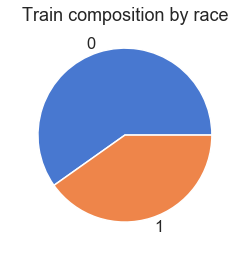

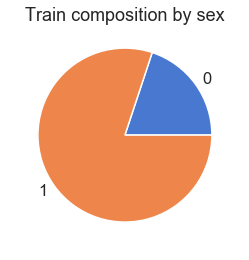

In [34]:
# Pie plot to verify composition by race and sex
race_train = train_data.groupby('race').size()
sex_train = train_data.groupby('sex').size()
race_train.plot(kind='pie', subplots=True, figsize=(4, 4))
plt.title("Train composition by race")
plt.ylabel("")
plt.show()

sex_train.plot(kind='pie', subplots=True, figsize=(4, 4))
plt.title("Train composition by sex")
plt.ylabel("")
plt.show()

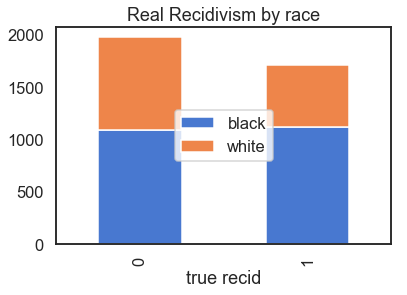

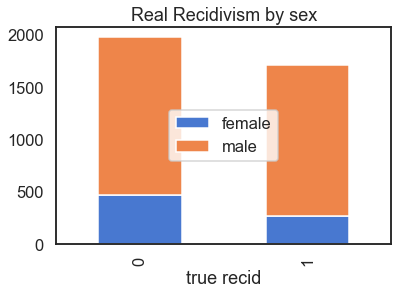

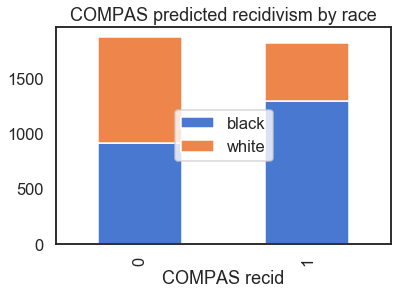

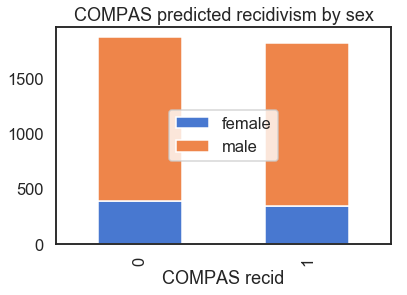

In [41]:
# Bar plot to verify prediction of COMPAS vs Real recidivism by sex and race
train_data.groupby(['true recid','race']).size().unstack().plot(kind='bar',stacked=True, 
                                                            title = 'Real Recidivism by race')
plt.legend(labels = ['black','white'], loc = 'center')
plt.show()
train_data.groupby(['true recid','sex']).size().unstack().plot(kind='bar',stacked=True, title = 'Real Recidivism by sex')
plt.legend(labels = ['female', 'male'], loc = 'center')
plt.show()
train_data.groupby(['COMPAS recid','race']).size().unstack().plot(kind='bar',stacked=True, title = 'COMPAS predicted recidivism by race')
plt.legend(labels = ['black','white'], loc = 'center')
plt.show()
train_data.groupby(['COMPAS recid','sex']).size().unstack().plot(kind='bar',stacked=True, title = 'COMPAS predicted recidivism by sex')
plt.legend(labels = ['female', 'male'], loc = 'center')
plt.show()

# First Conclusions

Based on data exploration, we can conclude that, as expected, the data set AS IS is not balanced with respect to race and sex. 

This alone is a big red flag in terms of bias and a relevant factor to keep in mind when interpreting model results. 